In [1]:
import os
import numpy as np
import torch
import tifffile
from sklearn.model_selection import train_test_split
from cellpose import models, train, io

In [2]:
data_dir = '/root/capsule/data/iGluSnFR_Soma_Annotation'

image_files = sorted([f for f in os.listdir(data_dir) if f.endswith('_merged.tif')])
mask_files = sorted([f for f in os.listdir(data_dir) if f.endswith('_segmented_v2.tif')])

assert len(image_files) == len(mask_files), "Number of images and masks must match."

images = [tifffile.imread(os.path.join(data_dir, img))[:, 1, :, :] for img in image_files]
masks = [tifffile.imread(os.path.join(data_dir, msk)).astype(np.uint16) for msk in mask_files]

for img, msk in zip(images, masks):
    assert img.shape[0] == msk.shape[0], "Number of frames in images and masks must match."

# Convert lists to numpy arrays
images = np.concatenate(images, axis=0)
masks_uint8 = np.concatenate(masks, axis=0).astype(np.uint16)

In [3]:
model = models.CellposeModel(gpu=True, model_type='cyto3', device=torch.device(f"cuda:1"))

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [4]:
# Evaluate the model on the test set
results = model.eval(images, channels=[0, 0])

# Visualize results for one of the test images
# from cellpose import plot
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# plot.show_segmentation(fig, test_images[0], masks_pred[0], flows[0], channels=[0, 0])
# plt.show()

z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020201/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only


In [5]:
masks_pred, flows, style = results

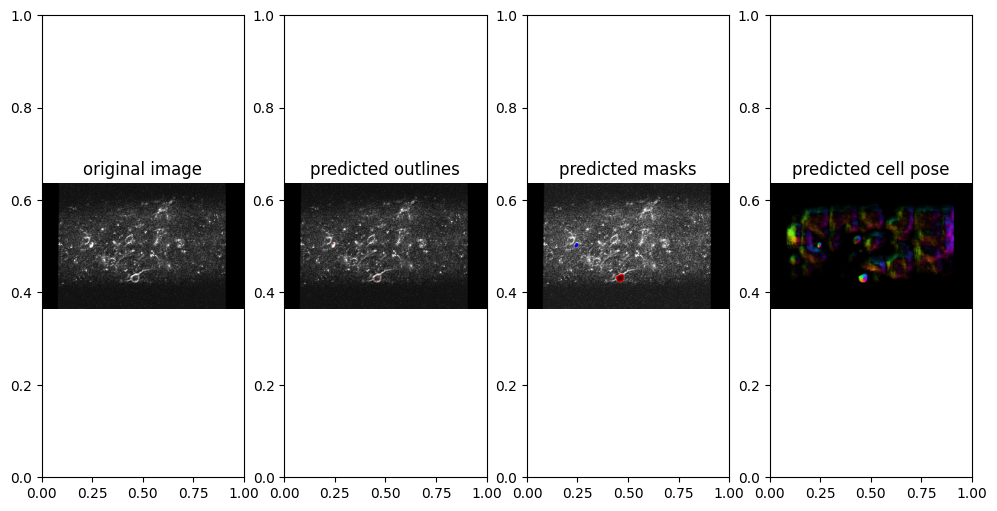

In [7]:
# Visualize results for one of the test images
from cellpose import plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 4, figsize=(12, 6))
plot.show_segmentation(fig, images[0], masks_pred[0], flows[0][0], channels=[0, 0])
plt.show()

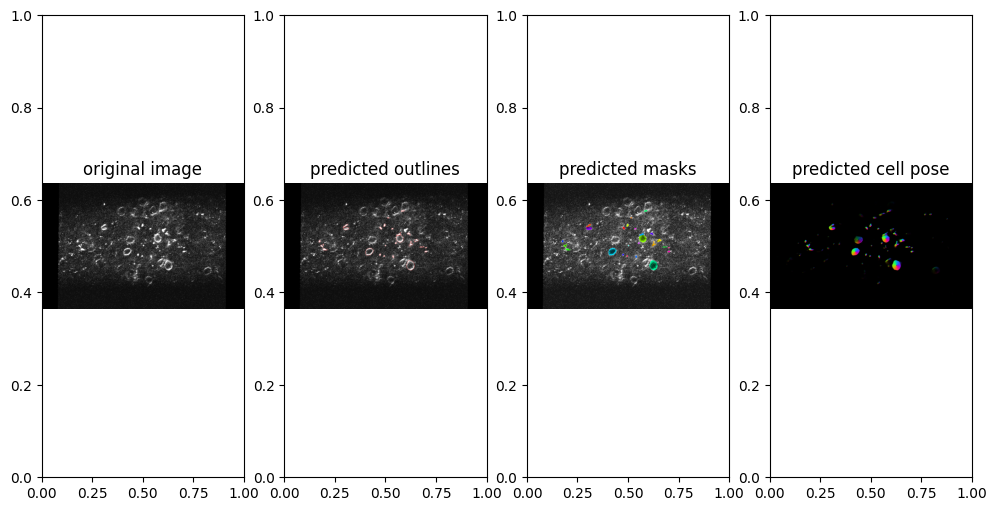

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(12, 6))
plot.show_segmentation(fig, images[10], masks_pred[10], flows[0][10], channels=[0, 0])
plt.show()

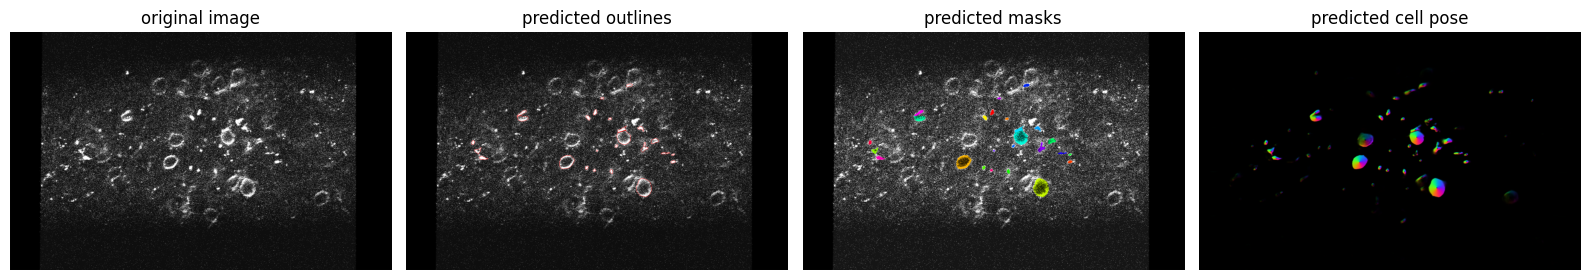

In [8]:
import matplotlib.pyplot as plt
from cellpose import plot

def overlay_true_mask(ax, image, true_mask, alpha=0.5):
    ax.imshow(image, cmap='gray')  # Display the original image
    ax.imshow(true_mask, cmap='gray', alpha=alpha)  # Overlay the true mask with transparency
    ax.set_title('True Mask Overlay')
    ax.axis('off')

# Assuming images, masks_pred, and flows are already defined
fig = plt.figure(figsize=(16, 6))

# Plot original image with predicted segmentation
plot.show_segmentation(fig, images[10], masks_pred[10], flows[0][10], channels=[0, 0])

# # Create a new subplot for the true mask overlay
# ax = fig.add_subplot(1, 2, 2)
# overlay_true_mask(ax, images[10], masks_uint8[10])

plt.tight_layout()
plt.show()

In [81]:
print(masks_pred.dtype)

uint16


In [12]:
from cellpose import metrics

# Assuming masks_pred and masks_true are your predicted and true masks
aji = metrics.aggregated_jaccard_index(masks_uint8, masks_pred)
ap, tp, fp, fn = metrics.average_precision(masks_uint8, masks_pred, threshold=[0.5])


# Calculate precision
precision = tp / (tp + fp)

# Calculate recall
recall = tp / (tp + fn)

print(f"Aggregated Jaccard Index: {aji}")
print(f"Average Precision: {ap}")
print(f"True Positives: {tp}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")

print(f"precision: {precision}")
print(f"recall: {recall}")

Aggregated Jaccard Index: [0.44509091 0.3862886  0.25365172 0.23134042 0.13017154 0.16396855
 0.21148335 0.17290553 0.30393803 0.25069777 0.27912573 0.29710546
 0.36838591 0.30814346 0.12405676 0.16101346 0.36271704 0.56538428
 0.40378878 0.48477771 0.32113449 0.19506636 0.35010678 0.10877485
 0.36166454 0.         0.33209624 0.24041059 0.11657682 0.20905539
 0.30613254 0.43043512 0.55290152 0.4921238  0.50263177 0.29542921
 0.28525369 0.41656294 0.31542429 0.41911487 0.0519248  0.17787189
 0.33201825 0.16768945 0.16075771 0.19799209 0.20896282 0.2506911
 0.23967189 0.22087396 0.25023764 0.21346599 0.15901031 0.20066947
 0.16246211 0.18996953 0.16159406 0.12842074 0.15279227 0.13864725
 0.19583724 0.15211988 0.26722281 0.24361597 0.18530967 0.2135152
 0.20309875 0.07402386 0.11670239 0.14144392 0.12566965 0.21599766
 0.18326052 0.27668324 0.31125816 0.35247456 0.3091823  0.25060236
 0.15456574 0.10011326 0.09492066 0.12033898 0.14394    0.2353899
 0.29302897 0.20836082 0.2932652  0.250

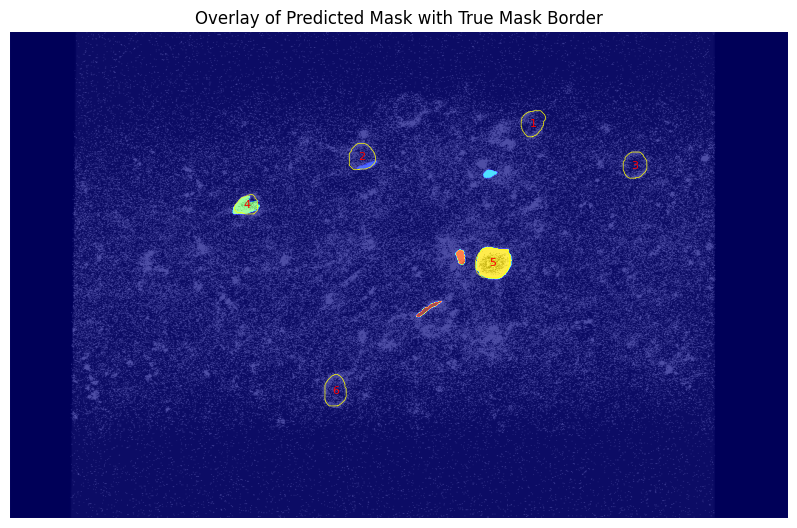

In [57]:
import matplotlib.pyplot as plt
from cellpose import plot
import numpy as np
from skimage import measure

def overlay_masks_with_border_and_labels(ax, image, predicted_mask, true_mask, alpha_pred=0.7):
    ax.imshow(np.clip(image + 250, 0, 255), cmap='gray')  # Display the original image
    ax.imshow(predicted_mask, cmap='jet', alpha=alpha_pred)  # Overlay the predicted mask in 'jet'
    
    # Find contours for the true mask and plot them without filling
    contours = measure.find_contours(true_mask, 0.5)
    for i, contour in enumerate(contours):
        ax.plot(contour[:, 1], contour[:, 0], linewidth=0.5, color='yellow')  # Draw border in yellow
        # Calculate and plot label at the centroid of each contour
        centroid = np.mean(contour, axis=0)
        ax.text(centroid[1], centroid[0], str(i+1), color='red', fontsize=8, ha='center', va='center')
    
    ax.set_title('Overlay of Predicted Mask with True Mask Border')
    ax.axis('off')

# Assuming images, masks_pred, and flows are already defined
fig = plt.figure(figsize=(16, 6))

# Create a new subplot for the combined overlay
ax = fig.add_subplot(1, 2, 2)
overlay_masks_with_border_and_labels(ax, images[20], masks_pred[20], masks_uint8[20])

plt.tight_layout()
plt.show()

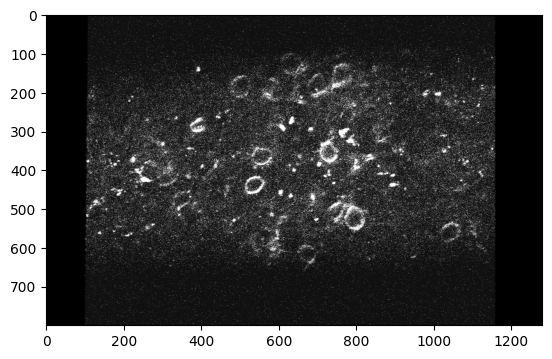

In [66]:
plt.imshow(np.clip(images[10] + 240, 0, 255) ,cmap='gray')

In [10]:
print(masks_pred.dtype, masks_uint8.dtype)

uint16 uint16


In [45]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Example binary masks (replace these with your actual data)
true_mask = masks_uint8[10]
pred_mask = masks_pred[10]

# Flatten the masks to compute metrics
true_mask_flat = true_mask.flatten()
pred_mask_flat = pred_mask.flatten()

# Calculate precision
precision = precision_score(true_mask_flat, pred_mask_flat, average = 'macro')
print('Precision:', precision)

# Calculate recall
recall = recall_score(true_mask_flat, pred_mask_flat, average = 'macro')
print('Recall:', recall)

# Calculate F1 score
f1 = f1_score(true_mask_flat, pred_mask_flat, average = 'macro')
print('F1 Score:', f1)

Precision: 0.06823008473576714
Recall: 0.060673030201259026
F1 Score: 0.06387381971598188


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [6]:
plt.imshow(masks_uint8[20])

NameError: name 'plt' is not defined

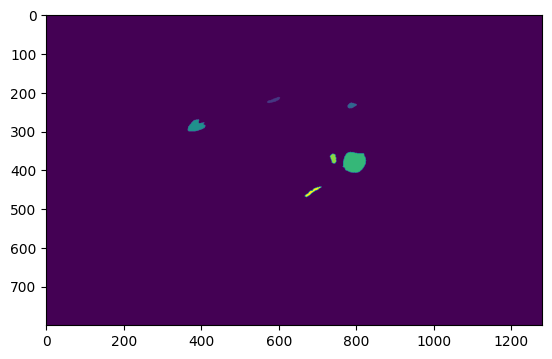

In [52]:
plt.imshow(masks_pred[20])

In [13]:
import numpy as np
from stardist import matching

def calculate_metrics(true_masks, pred_masks):
    # Assuming true_masks and pred_masks are numpy arrays
    # where each array contains binary masks for each object
    
    # Match predicted masks with true masks
    tp, fp, fn = matching.matching(true_masks, pred_masks, thresh=0.5)
    
    # Calculate precision, recall, and F1 score
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    
    return precision, recall, f1

true_mask = masks_uint8[20]
pred_mask = masks_pred[20]

precision, recall, f1_score = calculate_metrics(true_mask, pred_mask)
print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1_score}")

ValueError: too many values to unpack (expected 3)

In [65]:
masks_uint8.shape

(168, 800, 1280)

In [14]:
true_mask = masks_uint8[20]
pred_mask = masks_pred[20]
matching.matching(true_mask, pred_mask, thresh=0.5)

Matching(criterion='iou', thresh=0.5, fp=4, tp=2, fn=4, precision=0.3333333333333333, recall=0.3333333333333333, accuracy=0.2, f1=0.3333333333333333, n_true=6, n_pred=6, mean_true_score=0.266598383585612, mean_matched_score=0.7997951507568359, panoptic_quality=0.266598383585612)

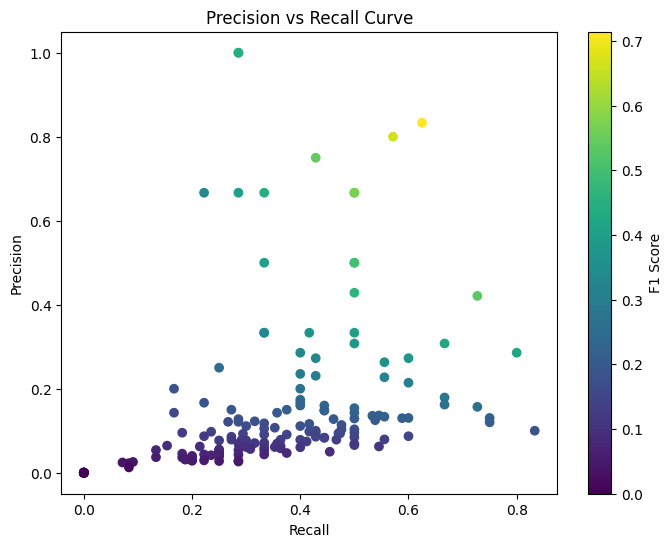

In [15]:
import numpy as np
from stardist import matching
import matplotlib.pyplot as plt

# Initialize lists to store precision and recall values
precisions = []
recalls = []
f1_scores = []

# Loop through masks_uint8 and masks_pred
for true_mask, pred_mask in zip(masks_uint8, masks_pred):
    # Perform matching
    match_result = matching.matching(true_mask, pred_mask, thresh=0.5)
    
    # Append precision, recall, and F1 score to the lists
    precisions.append(match_result.precision)
    recalls.append(match_result.recall)
    f1_scores.append(match_result.f1)

# Sort F1 scores and corresponding precisions and recalls
sorted_indices = np.argsort(f1_scores)[::-1]  # Sort in descending order
sorted_precisions = np.array(precisions)[sorted_indices]
sorted_recalls = np.array(recalls)[sorted_indices]
sorted_f1_scores = np.array(f1_scores)[sorted_indices]

# Plot precision vs recall curve
plt.figure(figsize=(8, 6))
plt.scatter(sorted_recalls, sorted_precisions, c=sorted_f1_scores, cmap='viridis')
plt.colorbar(label='F1 Score')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs Recall Curve')
plt.show()